# Coursework 2 - Exploration

Importing modules

In [17]:
#dataframe handling
import pandas as pd
#mathematics
import numpy as np

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#encoding
!pip install category_encoders
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

#What it says on the tin
from sklearn.model_selection import train_test_split

#outlier detection
from sklearn.cluster import DBSCAN

#imputer
from sklearn.impute import KNNImputer, SimpleImputer

#clustering checkers
from sklearn.metrics import silhouette_score, davies_bouldin_score

#feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from scipy.stats import spearmanr

#upsampling
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

print('Modules loaded')

Modules loaded


Importing the data

In [18]:
disease_train     = pd.read_csv('disease_train.csv')
#disease_test      = pd.read_csv('disease_test.csv') 
#predicted_target  = pd.read_csv('predictedTarget.csv') 

print('Data loaded')

Data loaded


# Exploration & Visualisation

Lets take an intial look at the dataset, we avoid truncation of the columns

In [19]:
pd.set_option('display.max_columns', None)

disease_train.head()

,id,age,gender,sick,pregnant,test_X1,test_X2,test_X3,test_X4,test_X5,test_X6,concern_type1,concern_type2,enlargement,tumor,disorder,medication_A,medication_B,mental_health,mood_stabiliser,surgery,treatment_type1,suspect,target
0,PA1001,59,male,no,no,7.8,NaN,89.0,0.85,105.0,NaN,no,yes,no,no,no,no,no,no,no,no,no,no,moderate_risk
1,PA1002,48,female,no,no,1.5,2.5,101.0,0.97,104.0,NaN,no,no,no,no,no,yes,no,no,yes,no,no,no,low_risk
2,PA1003,77,male,no,no,7.3,1.2,57.0,1.28,44.0,NaN,no,no,no,no,no,no,no,no,no,no,no,no,moderate_risk
3,PA1004,42,female,no,no,1.2,2.5,106.0,0.98,108.0,27.0,no,no,no,no,no,no,no,no,no,no,no,no,low_risk
4,PA1005,38,female,no,no,0.6,1.9,95.0,NaN,NaN,NaN,no,no,no,no,no,no,no,no,no,no,no,no,low_risk


Let's start our visualisation by looking at the balancing of the target variable.

low_risk         3612
moderate_risk     489
high_risk         149
Name: target, dtype: int64


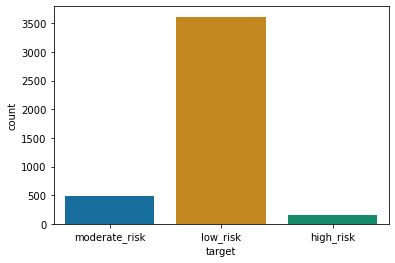

In [20]:
sns.countplot(x= 'target', palette='colorblind', data=disease_train)

print(disease_train['target'].value_counts())

We can see we have a very unbalanced distribution of target variables. Let's get a list of all the columns in our data set and some basic information about data types.


In [21]:
list(disease_train.columns)

['id',
 'age',
 'gender',
 'sick',
 'pregnant',
 'test_X1',
 'test_X2',
 'test_X3',
 'test_X4',
 'test_X5',
 'test_X6',
 'concern_type1',
 'concern_type2',
 'enlargement',
 'tumor',
 'disorder',
 'medication_A',
 'medication_B',
 'mental_health',
 'mood_stabiliser',
 'surgery',
 'treatment_type1',
 'suspect',
 'target']

In [22]:
disease_train.info() #This can help identify data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               4250 non-null   object 
 1   age              4250 non-null   int64  
 2   gender           4109 non-null   object 
 3   sick             4250 non-null   object 
 4   pregnant         4250 non-null   object 
 5   test_X1          3839 non-null   float64
 6   test_X2          3007 non-null   float64
 7   test_X3          4034 non-null   float64
 8   test_X4          3858 non-null   float64
 9   test_X5          3863 non-null   float64
 10  test_X6          154 non-null    float64
 11  concern_type1    4250 non-null   object 
 12  concern_type2    4250 non-null   object 
 13  enlargement      4250 non-null   object 
 14  tumor            4250 non-null   object 
 15  disorder         4250 non-null   object 
 16  medication_A     4250 non-null   object 
 17  medication_B  

There are four different types of data present: Integer, Rational, Boolean, Categorical. For simplicity they are group into, Numerical (Integer, Rational) and Categorical (Boolean, Categorical)

In [23]:
#Categorical
disease_bool = ['sick',            'pregnant',      'concern_type1',   'concern_type2',
                'enlargement',     'tumor'   ,      'disorder',        'medication_A',
                'medication_B',    'mental_health', 'mood_stabiliser', 'surgery',
                'treatment_type1', 'suspect']
disease_cate = ['id', 'gender', 'target']

#Numerical
disease_int  = ['age']
disease_rat  = ['test_X1', 'test_X2', 'test_X3', 'test_X4', 'test_X5', 'test_X6']

#Grouping the lists, doing it this way can lead to odd orderings but in this case happily it doesn't 
disease_cat = disease_cate + disease_bool
disease_num = disease_int + disease_rat

In [24]:
pd.set_option('display.max_rows', None) #So that the next table isn't truncated

#Gives us a count of the unique values in each cell, this can help identify boolean vs categorical variables
unique_count = disease_train.nunique() 

print(unique_count)

id                 4250
age                  94
gender                2
sick                  2
pregnant              2
test_X1             334
test_X2              77
test_X3             245
test_X4             124
test_X5             263
test_X6              25
concern_type1         2
concern_type2         2
enlargement           2
tumor                 2
disorder              1
medication_A          2
medication_B          2
mental_health         2
mood_stabiliser       2
surgery               2
treatment_type1       2
suspect               2
target                3
dtype: int64


Notice disorder only has a single variable, so we'll exclude it from visualisations (we come back to this in feature selection).

From the previous header table we should notice missing values in the test columns (in particular the 6th test). Let's gather a count of the missing values in each of the columns.

In [25]:
null_count = disease_train.isna().sum() #Creates a count of all the null values in collumns

#We'll use a for loop to pick out the nonzero columns, this is just to display it nicely
for col in disease_train:
    if null_count[col] != 0:
        print(col,' ',null_count[col])

gender   141
test_X1   411
test_X2   1243
test_X3   216
test_X4   392
test_X5   387
test_X6   4096


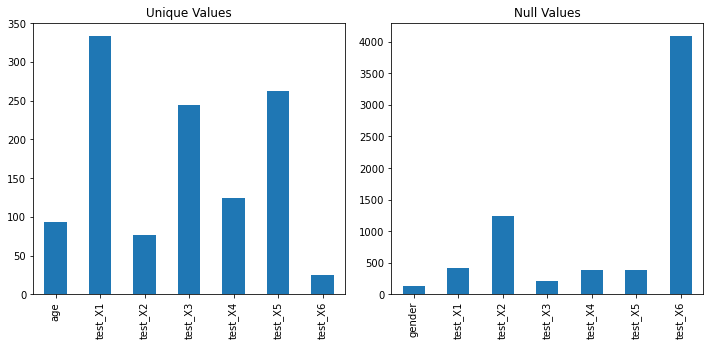

In [26]:
#Remove categoricals for both unique values and null values then plot bargraphs for both side by side
unique_count_num = disease_train[disease_num].nunique()
null_count = null_count[null_count != 0]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
unique_count_num.plot(kind='bar', title = 'Unique Values')

plt.subplot(1, 2, 2)
null_count.plot(kind='bar', title = 'Null Values')

plt.subplots_adjust(wspace=0.15)

plt.show()

We come back to the missing values in feature selection. Duplicate Rows are checked for.

In [27]:
duplicate_count = disease_train.duplicated().sum()
print(duplicate_count)

0


Let's take a quick look at the distribution of our numerical variables, we'll do this with a boxplot

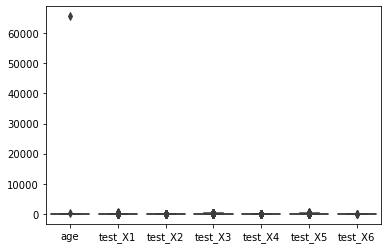

In [28]:
sns.boxplot(data = disease_train)

plt.show() #This also helps confirm our numerical split

In [29]:
#Let's find the outliers in age so we can replot this graph with more reasonably scaled y axis

for num in disease_train.age:
    if num > 100 or num <0: #Range set based on a realistic max age from intuition
        print(num)

65526
455


Interestingly we find an outlier that wasn't obvious in the intial box plot

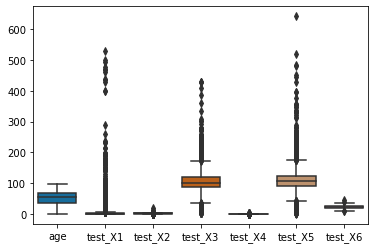

In [30]:
#Let's remove the two outliers
disease_train_agesremoved = disease_train[(disease_train['age'] != 65526) & (disease_train['age'] != 455)] 

#Replotting
sns.boxplot(data = disease_train_agesremoved, palette='colorblind')

plt.show() #Now we can see the outliers for the test columns

Since some of the test values are still squished let's seperate them into individual boxplots

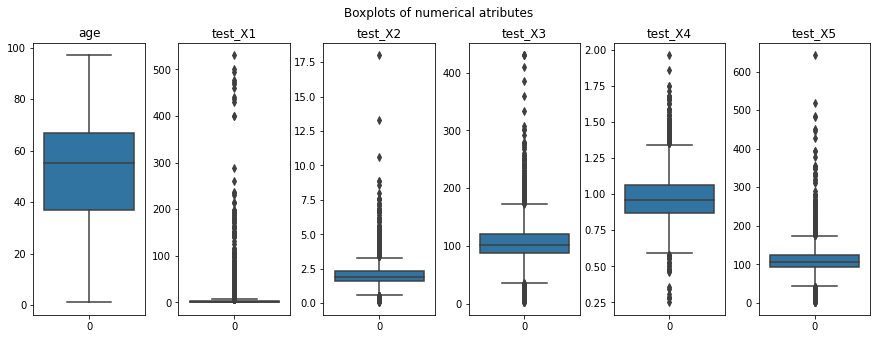

In [39]:
fig, (ax) = plt.subplots(1,6, figsize = (15,5))
fig.suptitle('Boxplots of numerical atributes')

disease_num_2 = [
                 'age', 'test_X1', 'test_X2',
                 'test_X3', 'test_X4', 'test_X5'
                ]

for i in range(len(disease_num_2)):
    #print(disease_num[i])
    sns.boxplot(data = disease_train_agesremoved[disease_num_2[i]], ax=ax[i])
    ax[i].set_title(disease_num_2[i])
    #print(disease_train_agesremoved[disease_num[i]])
    plt.subplots_adjust(wspace=0.3)

In [15]:
#Split the data by the 3 target types
disease_target_low      = disease_train.loc[(disease_train.target.str.strip() == 'low_risk')]
disease_target_moderate = disease_train.loc[(disease_train.target.str.strip() == 'moderate_risk')]
disease_target_high     = disease_train.loc[(disease_train.target.str.strip() == 'high_risk')]

Below we create distribution plots for each test compared with target (i.e. low, moderate or high risk)

In [16]:
#Code for a single plot

#sns.kdeplot(data=disease_target_low['test_X1'],label='low', shade=True)
#sns.kdeplot(data=disease_target_moderate['test_X1'],label='moderate', shade=True)
#sns.kdeplot(data=disease_target_high['test_X1'],label='high', shade=True)

#plt.title('Risk by test score for test 1')
#plt.legend()

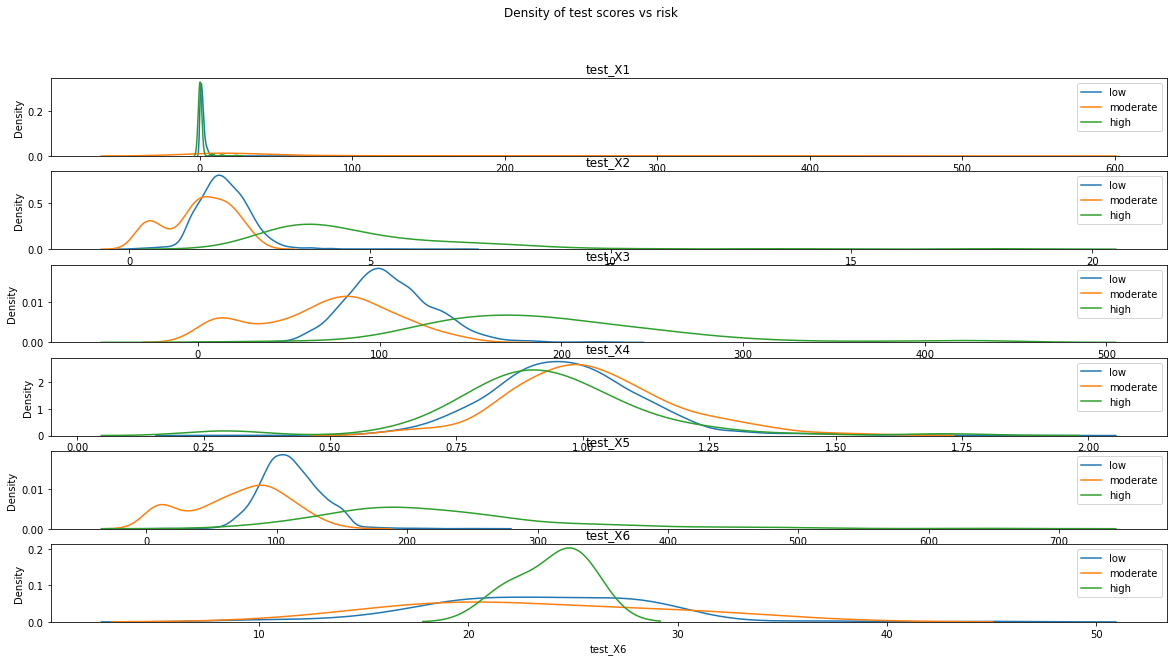

In [17]:
fig, ax_arr = plt.subplots(6, 1, figsize=(20, 10))
fig.suptitle('Density of test scores vs risk')

for i, ax in enumerate(ax_arr):
    test = 'test_X' + str(i + 1)
    
    #sns.kdeplot(data=disease_train[test], label='all risks', palette='colorblind', ax=ax)
    sns.kdeplot(data=disease_target_low[test], label='low', palette='colorblind', ax=ax)
    sns.kdeplot(data=disease_target_moderate[test], label='moderate', palette='colorblind', ax=ax)
    sns.kdeplot(data=disease_target_high[test], label='high', palette='colorblind', ax=ax)
    
    ax.set_title(test)
    ax.legend()  # Add legend to each subplot

plt.show()

Tests 2,3,5 appear to be good at finding a high risk people, they also appear to be highly similar in shapre, this means they're likely testing things that are highly correclated with eachother (3,5 might be the even more than 2 since they're in the same range of measurements).

Tests 1,4 appear to be bad at finding differences between highand low risks, although test 1 has some level of differentiation.

While test 6 might be good in combination with other tests at identifying high risk, it doesn't contain enough values to be considered good. 

We've done a decent amount of numerical data exploration, so we switch to exploring the catergorical data, we start with gender since it's the only one that has three categories.

<AxesSubplot:xlabel='gender', ylabel='count'>

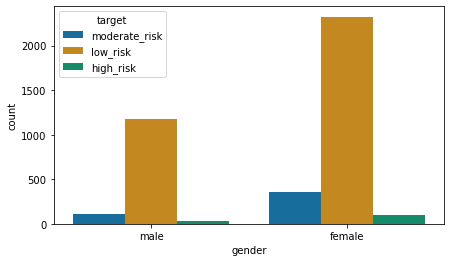

In [18]:
plt.figure(figsize=(7,4))
sns.countplot(x='gender', hue='target', palette='colorblind', data=disease_train )

<AxesSubplot:xlabel='gender', ylabel='count'>

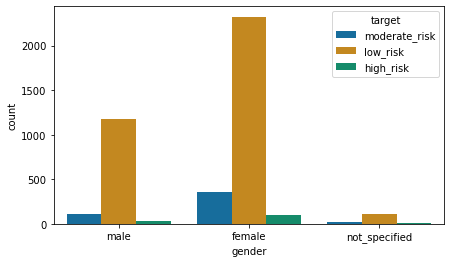

In [19]:
disease_train['gender'] = disease_train['gender'].fillna('not_specified') #let's us include this in the plot

plt.figure(figsize=(7,4))
sns.countplot(x='gender', hue='target', palette='colorblind', data=disease_train)

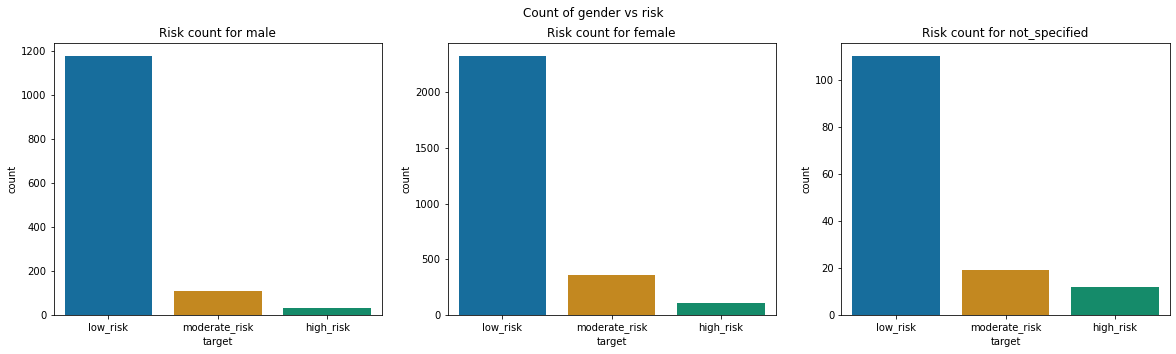

In [20]:
#To help visualise we split the graphs by gender

fig, ax_arr = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Count of gender vs risk')

gender = ['male','female','not_specified']
target_order = ['low_risk','moderate_risk','high_risk']

for i, ax in enumerate(ax_arr):
    test = gender[i]
    temp = disease_train[disease_train['gender'] == test]
    
    sns.countplot(x='target', palette='colorblind', data=temp, order=target_order,  ax=ax)
    
    test = 'Risk count for ' + test
    ax.set_title(test)
    
plt.subplots_adjust(hspace=1)
plt.show()

There's not obviously a link between gender and risk, other than maybe a small correlation with not specifeid. But it does appear there's more entries for female in the dataset, let's check that.

In [21]:
disease_train.gender.value_counts()

female           2787
male             1322
not_specified     141
Name: gender, dtype: int64

We were right, there's nearly double the number of female entries. Given there's such a disparity let's check the value counts of all the categorical columns.

In [22]:
#Since id is unique we remove it, 
#Similarly we remove target since we've already plotted it's distribution
#We remove disorder sinice we know it's constant

#This might be relevant when we balnce stuff later

disease_bool_2 = disease_bool.copy()
disease_bool_2.remove('disorder')

for category in disease_bool_2:
    print("-----", category, "-----")
    print(disease_train[category].value_counts())


----- sick -----
no     4095
yes     155
Name: sick, dtype: int64
----- pregnant -----
no     4235
yes      15
Name: pregnant, dtype: int64
----- concern_type1 -----
no     4183
yes      67
Name: concern_type1, dtype: int64
----- concern_type2 -----
no     3905
yes     345
Name: concern_type2, dtype: int64
----- enlargement -----
no     4215
yes      35
Name: enlargement, dtype: int64
----- tumor -----
no     4139
yes     111
Name: tumor, dtype: int64
----- medication_A -----
no     3760
yes     490
Name: medication_A, dtype: int64
----- medication_B -----
no     4196
yes      54
Name: medication_B, dtype: int64
----- mental_health -----
no     4056
yes     194
Name: mental_health, dtype: int64
----- mood_stabiliser -----
no     4205
yes      45
Name: mood_stabiliser, dtype: int64
----- surgery -----
no     4188
yes      62
Name: surgery, dtype: int64
----- treatment_type1 -----
no     4169
yes      81
Name: treatment_type1, dtype: int64
----- suspect -----
no     3951
yes     299
Name

Now we plot comparisons of risk with these variables.

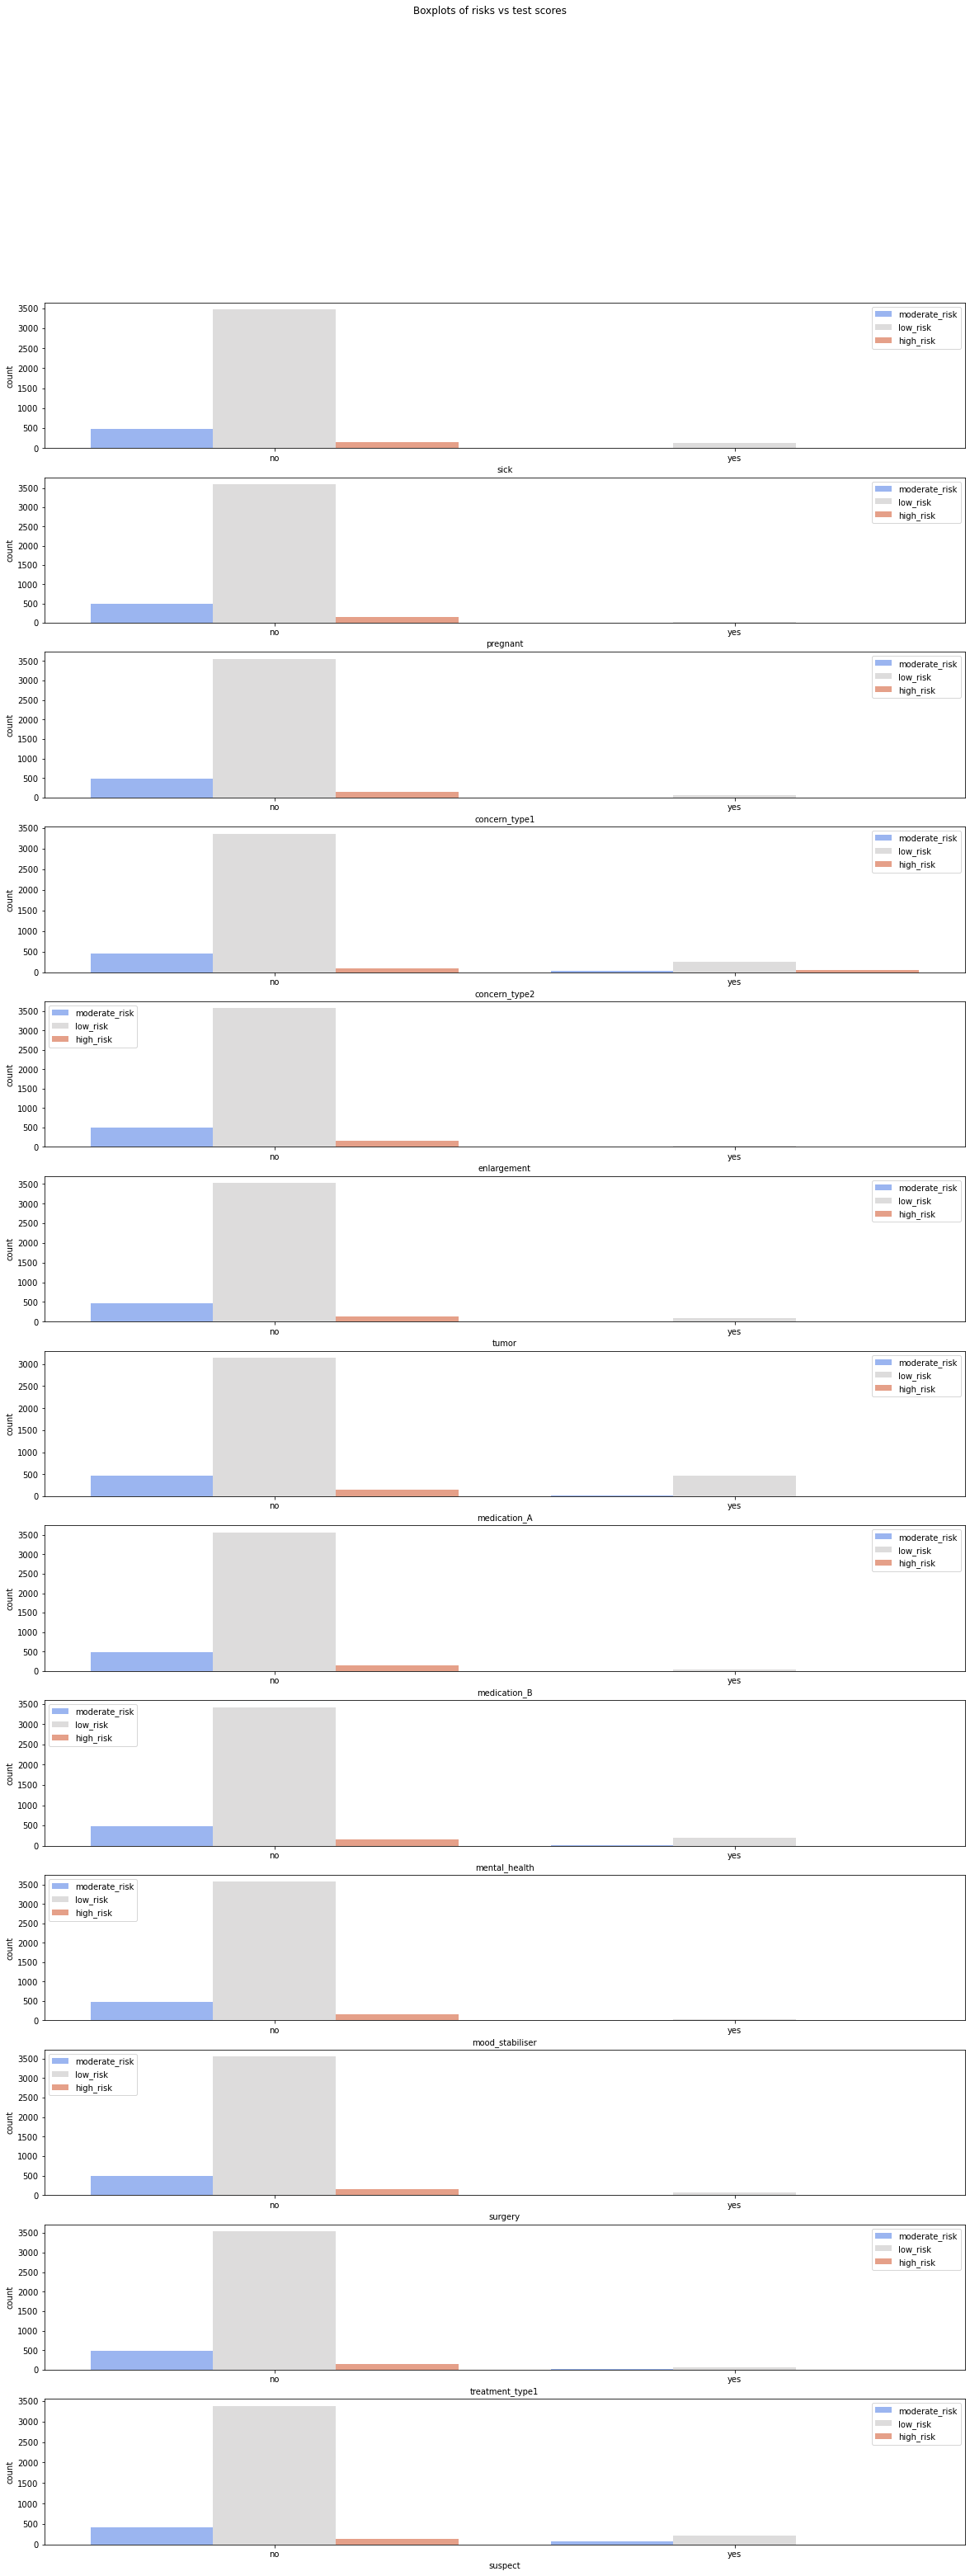

In [23]:
fig, ax_arr = plt.subplots(13, 1, figsize=(20, 50))
fig.suptitle('Boxplots of risks vs test scores')

answer_order = ['no','yes']


for i, ax in enumerate(ax_arr):
    test = disease_bool_2[i]
    sns.countplot(x=test, hue='target', palette="coolwarm",order=answer_order, data=disease_train, ax=ax)
        
    ax.legend()  # Add legend to each subplot

plt.show()

Let's seperate these box plots out by type of risk to identify any trends that might help with prediction.

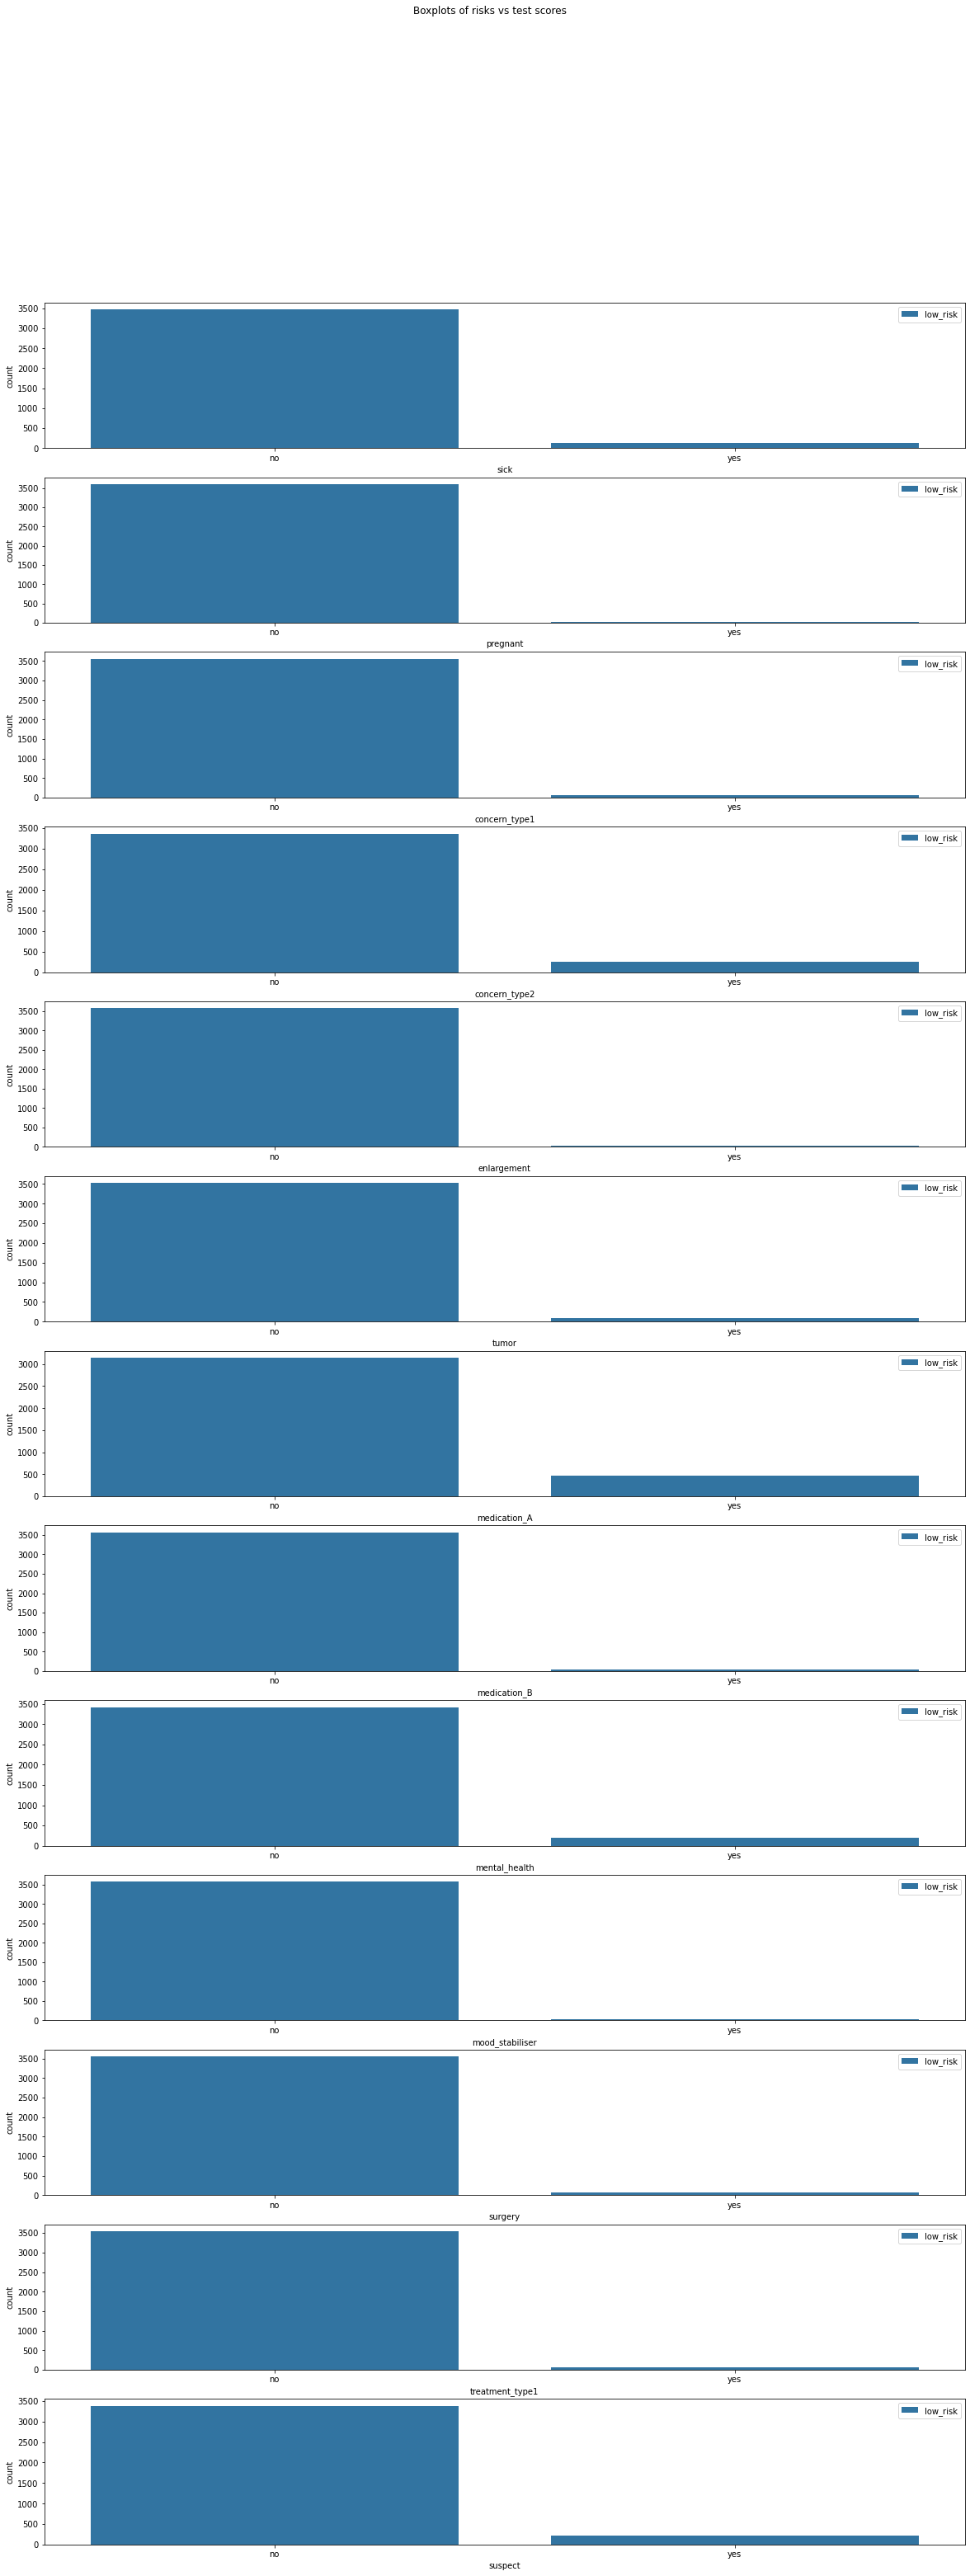

In [24]:
fig, ax_arr = plt.subplots(13, 1, figsize=(20, 50))
fig.suptitle('Boxplots of risks vs test scores')

answer_order = ['no','yes']

for i, ax in enumerate(ax_arr):
    test = disease_bool_2[i]
    sns.countplot(x=test, hue='target', data=disease_target_low, order=answer_order, ax=ax)
       
    #ax.set_title(test)
    ax.legend()  # Add legend to each subplot

plt.show()

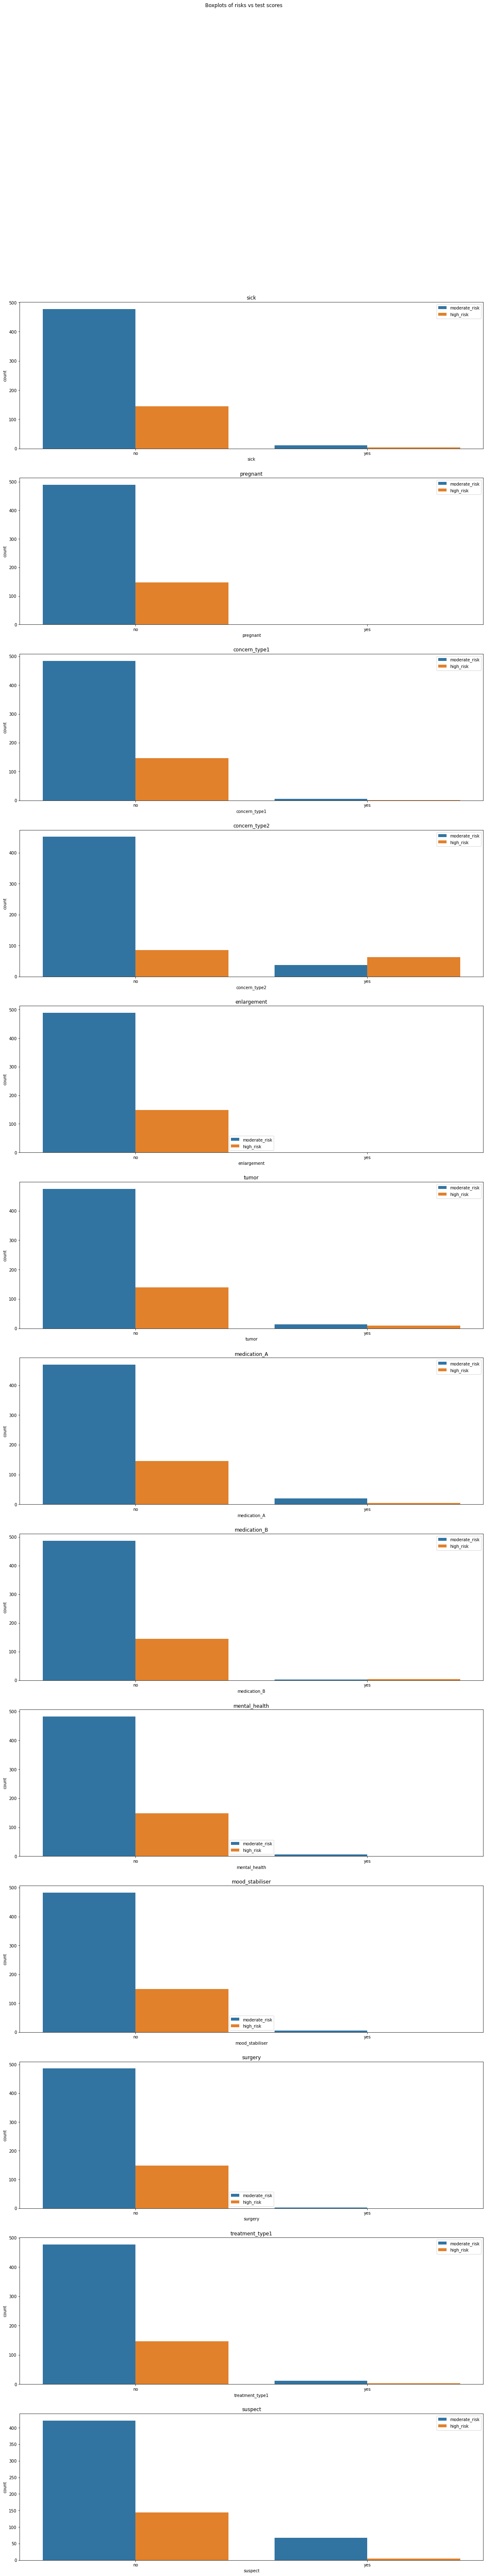

In [25]:
fig, ax_arr = plt.subplots(13, 1, figsize=(20, 100))
fig.suptitle('Boxplots of risks vs test scores')

disease_target_excllow = disease_train[disease_train['target'].isin(['moderate_risk', 'high_risk'])]

answer_order = ['no','yes']

for i, ax in enumerate(ax_arr):
    test = disease_bool_2[i]
    sns.countplot(x=test, hue='target', data=disease_target_excllow,order=answer_order,ax=ax)
        
    ax.set_title(test)
    ax.legend()  # Add legend to each subplot

plt.show()

# Preprocessing

## Feature selection

We want to specify our intial input and output variables.
First let's just create a list with all the variables except target in it, and one for target.

In [26]:
#Input
disease_input = ['id',              'age',           'gender',        'sick',            'pregnant',
                 'test_X1',         'test_X2',       'test_X3',       'test_X4',         'test_X5',   'test_X6',
                 'concern_type1',   'concern_type2', 'enlargement',   'tumor',           'disorder', 
                 'medication_A',    'medication_B',  'mental_health', 'mood_stabiliser', 'surgery',
                 'treatment_type1', 'suspect']

#Output
disease_output = ['target']

Now let's exclude some obvious columns from our input variables, reasons follow

- id, this is a key for finding a particular patient is not relevant to classification
- disorder, as stated this variable only takes one values, thus contributing no information
- test_X6, this variable has over 90% missing values so it can't reasonably be used

In [27]:
disease_input = ['age',             'gender',        'sick',          'pregnant',
                 'test_X1',         'test_X2',       'test_X3',       'test_X4',         'test_X5', 
                 'concern_type1',   'concern_type2', 'enlargement',   'tumor',            
                 'medication_A',    'medication_B',  'mental_health', 'mood_stabiliser', 'surgery',
                 'treatment_type1', 'suspect']

Some of the categorical variables are explored below. They are investigated based of their interesting bar graphs.

In [28]:
print("low risk")
print(disease_target_low["enlargement"].value_counts())
print("moderate risk")
print(disease_target_moderate["enlargement"].value_counts(), "")
print("high risk")
print(disease_target_high["enlargement"].value_counts(), "")

low risk
no     3577
yes      35
Name: enlargement, dtype: int64
moderate risk
no    489
Name: enlargement, dtype: int64 
high risk
no    149
Name: enlargement, dtype: int64 


Under the assumption enlarged refers to a tumor. 

This implies enlargement is a bad predictor, because while a yes answer might put you out of the high/moderate risk groups there may be other reasons for this people with enlarged tumours are far more susceptible to dying thus being excluded form the data set if they have complicating factors (survivorship bias). And a no answer implies very little.

In [29]:
print("low risk")
print(disease_target_low["pregnant"].value_counts())
print("moderate risk")
print(disease_target_moderate["pregnant"].value_counts(), "")
print("high risk")
print(disease_target_high["pregnant"].value_counts(), "")

low risk
no     3598
yes      14
Name: pregnant, dtype: int64
moderate risk
no    489
Name: pregnant, dtype: int64 
high risk
no     148
yes      1
Name: pregnant, dtype: int64 


In [30]:
counts_by_gender = disease_train.groupby('gender')['pregnant'].value_counts()

print(counts_by_gender)

gender         pregnant
female         no          2772
               yes           15
male           no          1322
not_specified  no           141
Name: pregnant, dtype: int64


Given the low number of entries yes, and the high correlation between having female as gender and pregnant as yes (i.e. it gives no new information), pregnant is probably a bad predictor. 

In [31]:
print("low risk")
print(disease_target_low["surgery"].value_counts())
print("moderate risk")
print(disease_target_moderate["surgery"].value_counts(), "")
print("high risk")
print(disease_target_high["surgery"].value_counts(), "")

low risk
no     3553
yes      59
Name: surgery, dtype: int64
moderate risk
no     486
yes      3
Name: surgery, dtype: int64 
high risk
no    149
Name: surgery, dtype: int64 


This implies surgery is a bad predictor, this is for the exact same reasons enlargement would be a bad predictor (survivorship bias).

Before procedeing further let's encode our categorical variables so that we can perform some correlation tests upon them.

## Encoding

In [32]:
display_1 = disease_train[disease_train['age'] == 65526][['age', 'target']]
display_2 = disease_train[disease_train['age'] == 455][['age', 'target']]

print(display_1)
print(display_2)

        age    target
2459  65526  low_risk
      age    target
3477  455  low_risk


First we should start with the ages removed data, this is because with age measurements so far outside of reasonability we can't trust the quality of the other measurements in those rows.

Also as can be seen above they're both low_risk so their removal is unlikely to affect predictions given the low_risk class is the majority class by a significant amount.

In [33]:
disease_cleansed = disease_train_agesremoved #Apologies in advance about all the commented out print statements, there was an indexing issue

A BinaryEncoder would better represent the data, however mutual_info doesn't respond to binary information very well so we save this for standardisation. (By using an ordinal encode all we need do is parse the columns and stubtract one in the process of standardisation).

In [49]:
#First let's encode the boolean variables
enc = ce.OrdinalEncoder(cols=disease_bool, handle_missing='return_nan',return_df= True)

encode1_disease=enc.fit_transform(disease_cleansed)

encode1_disease.head()

#print(encode1_disease.shape)

,id,age,gender,sick,pregnant,test_X1,test_X2,test_X3,test_X4,test_X5,test_X6,concern_type1,concern_type2,enlargement,tumor,disorder,medication_A,medication_B,mental_health,mood_stabiliser,surgery,treatment_type1,suspect,target
0,PA1001,59,male,0.0,0.0,7.8,NaN,89.0,0.85,105.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,moderate_risk
1,PA1002,48,female,0.0,0.0,1.5,2.5,101.0,0.97,104.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,low_risk
2,PA1003,77,male,0.0,0.0,7.3,1.2,57.0,1.28,44.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,moderate_risk
3,PA1004,42,female,0.0,0.0,1.2,2.5,106.0,0.98,108.0,27.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,low_risk
4,PA1005,38,female,0.0,0.0,0.6,1.9,95.0,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,low_risk


In [50]:
#Next we'll use OneHotEncoder to encode the gender variable
encode1_disease['gender'].fillna('empty', inplace=True)

# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

# passing gender columns
enc_gender = pd.DataFrame(enc.fit_transform(encode1_disease[['gender']]).toarray())
enc_gender.columns = ['G_empty', 'G_female', 'G_male']
#enc_gender.columns = enc.get_feature_names_out(['gender']) #if you want to fetch column names automatically
#print(enc_df)
#print(enc_gender.shape)


#Concatenate with previous data
#print(encode1_disease.shape)

#We need to do this so that when we concatonate we don't get an index issue and introduce null values and 2 extraineous rows
encode1_disease.reset_index(drop=True, inplace=True)

encode2_disease= pd.concat([encode1_disease, enc_gender], axis=1)
#print(encode2_disease.shape)

#Remove the original gender column
encode2_disease = encode2_disease.drop('gender', axis=1)

encode2_disease.head()

#print(encode2_disease.shape)

,id,age,sick,pregnant,test_X1,test_X2,test_X3,test_X4,test_X5,test_X6,concern_type1,concern_type2,enlargement,tumor,disorder,medication_A,medication_B,mental_health,mood_stabiliser,surgery,treatment_type1,suspect,target,G_empty,G_female,G_male
0,PA1001,59,0.0,0.0,7.8,NaN,89.0,0.85,105.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,moderate_risk,0.0,0.0,1.0
1,PA1002,48,0.0,0.0,1.5,2.5,101.0,0.97,104.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,low_risk,0.0,1.0,0.0
2,PA1003,77,0.0,0.0,7.3,1.2,57.0,1.28,44.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,moderate_risk,0.0,0.0,1.0
3,PA1004,42,0.0,0.0,1.2,2.5,106.0,0.98,108.0,27.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,low_risk,0.0,1.0,0.0
4,PA1005,38,0.0,0.0,0.6,1.9,95.0,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,low_risk,0.0,1.0,0.0


In [51]:
#Whilst skit-learn can usually handle target variables as strings we won't risk error and we'll label encode them
enc = ce.OrdinalEncoder(cols='target', handle_missing='return_nan',return_df= True)

encode3_disease=enc.fit_transform(encode2_disease)

encode3_disease.head()

,id,age,sick,pregnant,test_X1,test_X2,test_X3,test_X4,test_X5,test_X6,concern_type1,concern_type2,enlargement,tumor,disorder,medication_A,medication_B,mental_health,mood_stabiliser,surgery,treatment_type1,suspect,target,G_empty,G_female,G_male
0,PA1001,59,0.0,0.0,7.8,NaN,89.0,0.85,105.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,PA1002,48,0.0,0.0,1.5,2.5,101.0,0.97,104.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
2,PA1003,77,0.0,0.0,7.3,1.2,57.0,1.28,44.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,PA1004,42,0.0,0.0,1.2,2.5,106.0,0.98,108.0,27.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
4,PA1005,38,0.0,0.0,0.6,1.9,95.0,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0


Now that we've encoded our variables we can perform some feature selection tests, let's perform the mutual_info_classif test on all our variables.

Because of the OneHotEncoding we now need to re-label the input list

In [43]:
disease_input = ['age',             'sick',          'pregnant',
                 'test_X1',         'test_X2',       'test_X3',       'test_X4',         'test_X5', 
                 'concern_type1',   'concern_type2', 'enlargement',   'tumor',            
                 'medication_A',    'medication_B',  'mental_health', 'mood_stabiliser', 'surgery',
                 'treatment_type1', 'suspect',       'G_empty',       'G_female', 	     'G_male' ]

However because of the method for mutual info, we want all the possible variables so we create a temporary version of input for this, likely the variables we've already removed will be at the bottom of the list. (Id is still excluded for obvious reasons)

In [44]:
disease_input = ['age',             'sick',          'pregnant',
                 'test_X1',         'test_X2',       'test_X3',       'test_X4',         'test_X5',   'test_X6',
                 'concern_type1',   'concern_type2', 'enlargement',   'tumor',           'disorder', 
                 'medication_A',    'medication_B',  'mental_health', 'mood_stabiliser', 'surgery',
                 'treatment_type1', 'suspect', 'G_empty',       'G_female',      'G_male' ]

We impute variables so they are better handled by our mutual info test, median is used since mean doesn't work because of the skew (mode is reserved for categorical variables).

In [52]:
#Configure to select all features
selector = SelectKBest(score_func=mutual_info_classif, k='all')

#Select the relevant parts of the data frame
disease_intput_data = encode3_disease[disease_input].copy()
disease_output_data = encode3_disease.target.copy()

#----- Initial attempt at imputation for this test, problematic since it'll change distributions

# #We do this so that our test can handle null values
# disease_intput_data.fillna(0, inplace=True)
# disease_output_data.fillna(0, inplace=True)

#-----

#since simple imputer wants a 2D array
disease_output_data = np.array(disease_output_data).reshape(-1, 1)

# Initialize SimpleImputer with strategy='median'
imputer = SimpleImputer(strategy='median')

# Fit the imputer on data, Then perform the imputation
imputer.fit(disease_intput_data)
disease_input_data_imputed = imputer.transform(disease_intput_data)

#Repeat these steps for output
imputer.fit(disease_output_data)
disease_output_data_imputed = imputer.transform(disease_output_data)

#Back to 1D array for mutual info test
disease_output_data_imputed = disease_output_data_imputed[:,0]

In [55]:
#Reproducibility
#np.random.seed(404)

# transform train input data
Xfs = selector.fit_transform(disease_input_data_imputed,disease_output_data_imputed)

#Retrieve the column names for the selected columns
names = disease_intput_data.columns.values[selector.get_support()]
#and their scores
scores = selector.scores_[selector.get_support()]
#pair the values together with the zip function
names_scores = list(zip(names, scores))
#Store the information in a data frame
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'Mutual_info'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['Mutual_info', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

         Feat_names  Mutual_info
3           test_X1     0.381542
7           test_X5     0.186541
5           test_X3     0.165043
4           test_X2     0.124290
6           test_X4     0.024257
10    concern_type2     0.013690
13         disorder     0.010855
0               age     0.010796
8           test_X6     0.009258
14     medication_A     0.007943
12            tumor     0.007506
1              sick     0.006104
17  mood_stabiliser     0.002719
2          pregnant     0.002603
16    mental_health     0.001320
23           G_male     0.000960
21          G_empty     0.000351
22         G_female     0.000000
9     concern_type1     0.000000
11      enlargement     0.000000
15     medication_B     0.000000
18          surgery     0.000000
20          suspect     0.000000
19  treatment_type1     0.000000


This test relies on a random generator so beyond the first 5 results it becomes incresingly unreliable, especially given the high dimensoinality of the space. Regardless if you run this test mutiple times, test_X1,2,3,5 always turn up in the top 4. And quite often text_X4 also turns up in the top 5.

Whilst mutual information is useful it alone might not measure everytthing we'd like it too.

This measures monotonic relationships so it won't be perfectly accurate either, but if we combine it with mutual info we should get a good picture of of which features are useful.

In [56]:
spearman_corr = []

for col in disease_input:
    corr, p_value = spearmanr(disease_input_data_imputed[:, disease_intput_data.columns.get_loc(col)], disease_output_data_imputed)
    spearman_corr.append((corr, p_value))  # Append a tuple containing corr and p_value

#Turns the results into a dataframe for display purposes
spearman_corr_df = pd.DataFrame({'Feature': disease_input, 'Spearman_Corr': [cols[0] for cols in spearman_corr], 'P_Value': [cols[1] for cols in spearman_corr]})

#Sorts the dataframe by absolute value so we can see the highest correlations by they positive or negative
spearman_corr_df_sorted = spearman_corr_df.reindex(spearman_corr_df['Spearman_Corr'].abs().sort_values(ascending=False).index)
print(spearman_corr_df_sorted)

            Feature  Spearman_Corr        P_Value
3           test_X1      -0.572331   0.000000e+00
7           test_X5       0.415464  5.856365e-177
5           test_X3       0.399765  8.640187e-163
4           test_X2       0.275072   1.268708e-74
6           test_X4      -0.117264   1.759479e-14
10    concern_type2      -0.114690   6.497504e-14
20          suspect      -0.093272   1.124647e-09
0               age      -0.056158   2.502642e-04
14     medication_A       0.048276   1.647311e-03
22         G_female      -0.043543   4.532498e-03
23           G_male       0.039620   9.807699e-03
15     medication_B       0.034807   2.329270e-02
16    mental_health       0.027624   7.181923e-02
2          pregnant       0.023111   1.320501e-01
11      enlargement       0.020372   1.843444e-01
1              sick       0.018691   2.232391e-01
12            tumor       0.017407   2.566784e-01
17  mood_stabiliser      -0.014048   3.599834e-01
21          G_empty       0.013102   3.932578e-01


C:\Users\LODKe\anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


As with the previous, test_X 1 through 5 turn up in the same order in the top 5. So these are our essential features. OUr disregard of disorder and test_X6 is validated. 

From this test all the relationships after medication_B are above a p value of 0.05 so correlation isn't necessarily present. (Aside G_empty which we group with G_female & G_male since because of hotoneencodeing they're all from the same variable)

Since spearmans test implementation has nan handling in built, lets try running it with nan's ommitted and compare results (Since it's a pairqwise test we don't need to drop test_X6, however we already want to discard it we could encouurage wider usage of this test if the results are significant)

In [ ]:
spearman_corr = []

for col in disease_input:
    corr, p_value = spearmanr(disease_intput_data[col], disease_output_data, nan_policy='omit')
    spearman_corr.append((corr, p_value))  # Append a tuple containing corr and p_value

#Turns the results into a dataframe for display purposes
spearman_corr_df = pd.DataFrame({'Feature': disease_input, 'Spearman_Corr': [cols[0] for cols in spearman_corr], 'P_Value': [cols[1] for cols in spearman_corr]})

#Sorts the dataframe by absolute value so we can see the highest correlations by they positive or negative
spearman_corr_df_sorted = spearman_corr_df.reindex(spearman_corr_df['Spearman_Corr'].abs().sort_values(ascending=False).index)
print(spearman_corr_df_sorted)

The results are very similar with the ones from the imputed values, this not only back up the choice of features but implies median imputing is fairly robust and doesn't change the relationships of the data. 

Now we create a refined list of input features based on these tests. (we generally rely more on the spearman correlation than mutual information since beyond the top 5 mutual information is less reliable.)

In [ ]:
disease_input = [
                 'test_X1',       'test_X5',  'test_X3', 'test_X2',      'test_X4',
                 'concern_type2', 'suspect',  'age',     'medication_A', 'medication_B',
                 'G_empty',       'G_female', 'G_male',
                ]

- encode
- feature-selection
- traintest-split
- impute
- outlier detection
- balancing
- standardization

## Train Test split

We now perform a test train split, we do this on the non-imputed data.

This step being here is because we've defined our features of interest, but haven't performed any steps that would potentially cause issues with the validation or test data.

These steps and issues they can cause are, Imputing can cause data leakage, Balancing can make the data unrepresentative, Outlier removal can make the data unrepresentative. 

We may need to impute all the data for particular types of algorithm, we do this after the split and use the statistics from the training set to impute the validation and test sets. This lowers the chances of data leakage and makes the model and measurement of it more robust.

Later we go on to you a Knn imputation method, when passing the validation and test data, we need to use the model fitted to the training data, this should prevent data leakage. Also worth noting that because DBSCAN is used as a method of outlier detection and it can't handle null values, we impute the data before identifying and possibly removing outliers. 

This is why we choose knn imputation, since means are highly susceptible to outliers and also might not ctach all the nuances of the data, meanwhile medians are less suceptible to outliers but still can't catch nuances in the data. Knn imputation is capable of being robust to out liers and able to capture nuances in the data, although these two characteristics can end up being a trade off.

In [ ]:
# Check if any values in the 'age' column are greater than 100 and print them
age_above_100 = encode3_disease[encode3_disease['age'] > 100]
if not age_above_100.empty:
    print("Rows with age > 100:")
    print(age_above_100)
else:
    print("No rows with age > 100.")


In [ ]:
#Making sure input and output variables are correctly specified
disease_input = [
    'test_X1', 'test_X5', 'test_X3', 'test_X2', 'test_X4',
    'concern_type2', 'suspect', 'age', 'medication_A', 'medication_B',
    'G_empty', 'G_female', 'G_male'
]
disease_output = ['target']

disease_input_data = encode3_disease[disease_input].copy()
disease_output_data = encode3_disease[disease_output].copy()

print(encode3_disease.shape)

#Because test_train split can't handle nan values we change those to a place holder -999 which isn't present in our data,
#this let's us split the data without imputing any values so as to avoid data leakage,
# in theory we could drop null values instead but this would eliminate a significant portion of the data
disease_input_data_fix = disease_input_data.fillna(-999)

#The train test split
X_temp, X_test, y_temp, y_test = train_test_split(
    disease_input_data_fix, disease_output_data, test_size=0.2, random_state=42, stratify=disease_output_data
)

#The train validation split (0.25 since this will make validation and test the same size)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

# Check the shapes of the resulting splits to ensure correctness
print('Training set shape: ',X_train.shape, y_train.shape)
print('Validation set shape: ',X_val.shape, y_val.shape)
print('Test set shape: ',X_test.shape, y_test.shape)

In [ ]:
#Now we can replace our place holder with null values again
disease_input_data_fix.replace(-999, np.nan, inplace=True)
X_train.replace(-999, np.nan, inplace=True)
X_val.replace(-999, np.nan, inplace=True)
X_test.replace(-999, np.nan, inplace=True)

#Check it worked - and is relatively balanced
# print(disease_input_data_fix.isna().sum().sum() - disease_input_data.isna().sum().sum())
# print(X_train.isna().sum().sum()/disease_input_data_fix.isna().sum().sum())
# print(X_val.isna().sum().sum()/disease_input_data_fix.isna().sum().sum())
# print(X_test.isna().sum().sum()/disease_input_data_fix.isna().sum().sum())

# Outlier detection

I wanted to use DBSCAN here but unfortunately DBSCAN doesn't handle null values, so if we're to use DBSCAN we'll need to handle these, there are two approaches.

- Approach one is imputing the values missing in the test_X* columns. 
- Approach two is to disregard all rows with null entries, (to do this we need to disregard test_X2, since otherwise we remove 37% of the entries)

We'll try approach one and if it doesn't work we'll try approach two.

In [ ]:
#justifying the above reasoning
_rat2  =  ['test_X1','test_X2', 'test_X3', 'test_X4', 'test_X5']
_rat3  =  ['test_X1', 'test_X3', 'test_X4', 'test_X5']

X_train_rat2 = X_train[_rat2].copy()
X_train_rat2_purged = X_train_rat2.dropna()

print('2 shape ', X_train_rat2_purged.shape)

X_train_rat3 = X_train[_rat3].copy()
X_train_rat3_purged = X_train_rat3.dropna()

print('3 shape ',X_train_rat3.shape)

#Percentages
#print(3619/4250 * 100)
#print(2713/4250 * 100)

In [ ]:
# X_train_rat2.describe() #To let us compare before and after imputation
encode3_disease.isnull().sum()
X_train_rat2.isnull().sum()

Worth noting that we need only impute the continuous columns since our categorical columns don't have any missing entries. We'll use knn imputation for reasons outlined previously. 

# BEFORE KKN IMPUTATION YOU NEED TO STANDARDISE OTHERWISE YOU PREFERENCE CLUSTERS AROUND LARGE SCALES.#

# BUT YOU CAN'T STANDARDISE WITH OUTLIERS PRESENT WOMP WOMP

In [ ]:
nan = np.nan

#Create KNN imputer - with distance or uniform
#imputer = KNNImputer(n_neighbors=10, weights="uniform")
imputer = KNNImputer(n_neighbors=10, weights="distance")

#Creating smaller dataframes with only data needed
X_train_rat2  =  X_train[_rat2].copy()
X_test_rat2   =  X_test[_rat2].copy()
X_val_rat2    =  X_val[_rat2].copy()

#Fit the imputer to the training set
Imputed_results =imputer.fit(X_train_rat2)

#Impute our 3 partitions based on the above fit
X_train_imputed_temp  =  imputer.transform(X_train_rat2)
X_test_imputed_temp   =  imputer.transform(X_test_rat2)
X_val_imputed_temp    =  imputer.transform(X_val_rat2)

# Convert outputs to a dataframes to show the stats
X_train_imputed  =  pd.DataFrame(data=X_train_imputed_temp, columns=_rat2)
X_test_imputed   =  pd.DataFrame(data=X_test_imputed_temp, columns=_rat2)
X_val_imputed    =  pd.DataFrame(data=X_val_imputed_temp, columns=_rat2)

#Compare the imputed data to the original data
print(
X_train_imputed.describe() - X_train_rat2.describe(),
X_test_imputed.describe()  - X_test_rat2.describe(),
X_val_imputed.describe()   - X_val_rat2.describe(),
)

These appear to be very similar, the most notable differences are changes in stadard deviation however if we assume that there are outliers that caused a long tail then this would be the expected result from successful imputation that avoided being affected by the outliers.

We proceed with outlier detection. Since we've created the data frame with the values removed we can compare our outcomes from this step.

# DBSCAN

Since this is medical data, outlier removal has to be performed carefully. This is because the outliers may not be measurement failures but rather contain useful information, that being said performing outlier checking doesn't necessarily imply removal.

Also since this is medical data and we don't know the types of tests performed we can't easily infer rules as we did with age.

In [ ]:
#Data sets
#X_train_imputed
#X_test_imputed
#X_val_imputed

outlier_detection = DBSCAN(min_samples = 6, eps = 10)
clusters = outlier_detection.fit_predict(X_train_imputed)

TotalOutliers=list(clusters).count(-1)

print("Total number of outliers identified is: ",TotalOutliers)

We create a gridsearch of the DBSCAN to attempt to arrive at a good choice of hyperparameters. We do this by scoring each test with a silhouette score and a davies-boulin index. Looking for the best resutls in both to indicate the best grouping of results.

A silhouette score near 1 and a davie-boulin index near zero. 

In [ ]:
# # #Ascending numbers from 3 since a cluster of 2 point is just a pair
# # min_samples = [3,  4,  5,  6,  7,  8,   9,   10,  11,  12,  13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] 
# # #Epsilon above 10 from initial testing makes the most sense
# # eps         = [10,  11,  12,  13,  14,  15,  16,  17,  18,  19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

# #Ascending numbers from 3 since a cluster of 2 point is just a pair
# min_samples = [3,  4,  5,  6,  7,  8,   9,   10,  11,  12,  13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33] 
# #Due to sparseness whilst 10 was a good value for the whole data set, larger values will probably work better
# eps         = [10,  11,  12,  13,  14,  15,  16,  17,  18,  19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
#                33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]


# DBSCAN_Result = []

# for samples in min_samples:
#     for epsilon in eps:
#         #print('samples :',samples,'  eps: ',epsilon)
#         outlier_detection = DBSCAN(min_samples = samples, eps = epsilon)
#         clusters = outlier_detection.fit_predict(X_train_imputed)

#         TotalOutliers=list(clusters).count(-1)
#         #print('Number of outliers is: ',TotalOutliers)
        
#         silhouette = silhouette_score(X_train_imputed, clusters)
#         #print('Silhouette Score is: ', silhouette)

#         davies_bouldin = davies_bouldin_score(X_train_imputed, clusters)
#         #print('Davies-Bouldin Index is: ', davies_bouldin)

#         DBSCAN_Result.append((samples, epsilon, TotalOutliers, silhouette, davies_bouldin))

# Results= pd.DataFrame(DBSCAN_Result, columns=['samples', 'epsilon', 'Total Outliers', 'silhouette', 'davies_bouldin'])

# Results

In [ ]:
# Results = Results.sort_values(by=['silhouette', 'davies_bouldin'], ascending=[False, True])
# #Results = Results.sort_values(by=['davies_bouldin', 'silhouette'], ascending=[True, False])

# print(Results)
# print('Mean Outliers :', Results['Total Outliers'].mean())

<!-- Analysis of results with all of the data set
 
If we want to maxmise silhouette : 4/6 samples with 19 epsilon.
Outliers would then be:  77, 81, 89
So in otherwords minimise a chance of overlap between clusters.

If we want to minimise davies-boulin: 3 samples with 18/17 epsilon.
Outlier would then be: 66 or 80.
This would generally indicate good clusters with measures like similarity between clusters.

Both these results identify a similar number of outliers. 5, 19 is the choice to continue with (choosing seperation of clusters over davies-boulin allowing for more disimilarity between clusters then choosing davies-boulin first). And choosing 5,19 rather than the best to allow for slightly more generalizability. --> 

If we want to maxmise silhouette : 7 samples with 46/50 epsilon.
Outliers would then be:  18
So in otherwords minimise a chance of overlap between clusters.

If we want to minimise davies-boulin: 3/4 samples with 46/50 epsilon.
Outlier would then be: 7
This would generally indicate good clusters with measures like similarity between clusters.

Both these results identify a similar number of outliers. 7, 48 is the choice to continue with (choosing seperation of clusters over davies-boulin allowing for more disimilarity between clusters then choosing davies-boulin first). Not just because uniformity of cluster isn't necessarily important but also because it's not surprising that lower sample clusters have better 


Below I check that imputing values hasn't changed the outlier detection significantly.

In [ ]:
# # #Ascending numbers from 3 since a cluster of 2 point is just a pair
# # min_samples = [3,  4,  5,  6,  7,  8,   9,   10,  11,  12,  13] 
# # #Epsilon above 10 from initial testing makes the most sense
# # eps         = [10,  11,  12,  13,  14,  15,  16,  17,  18,  19]

# #Ascending numbers from 3 since a cluster of 2 point is just a pair
# min_samples = [3,  4,  5,  6,  7,  8,   9,   10,  11,  12,  13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33] 
# #Due to sparseness whilst 10 was a good value for the whole data set, larger values will probably work better
# eps         = [10,  11,  12,  13,  14,  15,  16,  17,  18,  19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
#                33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]

# DBSCAN_Result_purge = []

# for samples in min_samples:
#     for epsilon in eps:
#         #print('samples :',samples,'  eps: ',epsilon)
#         outlier_detection = DBSCAN(min_samples = samples, eps = epsilon)
#         clusters = outlier_detection.fit_predict(X_train_rat2_purged)

#         TotalOutliers=list(clusters).count(-1)
#         #print('Number of outliers is: ',TotalOutliers)
        
#         silhouette = silhouette_score(X_train_rat2_purged, clusters)
#         #print('Silhouette Score is: ', silhouette)

#         davies_bouldin = davies_bouldin_score(X_train_rat2_purged, clusters)
#         #print('Davies-Bouldin Index is: ', davies_bouldin)

#         DBSCAN_Result_purge.append((samples, epsilon, TotalOutliers, silhouette, davies_bouldin))

# Results_purge = pd.DataFrame(DBSCAN_Result, columns=['samples', 'epsilon', 'Total Outliers', 'silhouette', 'davies_bouldin'])

# Results_purge

In [ ]:
# #Results_purge = Results_purge.sort_values(by=['silhouette', 'davies_bouldin'], ascending=[False, True])
# Results_purge = Results_purge.sort_values(by=['davies_bouldin', 'silhouette'], ascending=[True, False])

# print(Results_purge)
# print('Mean Outliers :', Results_purge['Total Outliers'].mean())

Hapily the purged set and the imputed set behave identically under DBSCAN, (this isn't necessarily surprising since KNN imputation with a large number of neighbors i.e. 10 is relatively robust to outliers).

If there was time this metod could be repeated with several different values of k and the impact could be considered.

In [ ]:
#Outlier detection - NON GRIDSEARCH
outlier_detection = DBSCAN(min_samples = 7, eps = 48)
clusters = outlier_detection.fit_predict(X_train_imputed)

TotalOutliers=list(clusters).count(-1)

print("Total number of outliers identified is: ",TotalOutliers)

In [ ]:
# select all rows that are not outliers and create a boolean mask
mask = clusters != -1
inverse_mask = ~mask

# Apply mask to data and check shape
mask_outliers_1 = X_train_imputed[mask]
print(mask_outliers_1.shape)

# Apply inverse mask to data and check shape
mask_nonoutliers_1 = X_train_imputed[inverse_mask]
print(mask_nonoutliers_1.shape)

# Isolation forest

In [ ]:
# #import the implementation of this algorihm from sklearn
# from sklearn.ensemble import IsolationForest

# #Use the algorithm for outlier detection, then use it to predict each point
# #Any point labelled as -1 is an outlier
# clf = IsolationForest(max_samples=31258, random_state = 1, contamination= 0.01)
# preds = clf.fit_predict(train_OL_X)
# #print(preds)
# totalOutliers=0
# for pred in preds:
#     if pred == -1:
#         totalOutliers=totalOutliers+1
# print("Total number of outliers identified is: ",totalOutliers)

# # select all rows that are not outliers and create a boolean mask
# mask = preds != -1
# # Apply mask to y and check shape
# y2= train_y[mask]
# print (y2.shape)

# #Apply mask to X and check shape 
# X2=train_X[mask]
# print(X2.shape)

# Local Outlier Factor

In [ ]:
# from sklearn.neighbors import LocalOutlierFactor
# np.random.seed(42)

# # fit the model for outlier detection (default)
# clf = LocalOutlierFactor(n_neighbors=20, contamination=0.01)

# # use fit_predict to compute the predicted labels of the training samples
# # (when LOF is used for outlier detection, the estimator has no predict,
# # decision_function and score_samples methods).
# y_pred = clf.fit_predict(train_OL_X)

# #print ("Predicted outliers: \n",y_pred)

# #Calculate number of outliers
# outlierN = len([i for i in y_pred if i == -1])
# print ("Number of predicted outliers:",outlierN)


# #Let us see graphically how the outliers are identified
# #Use outlier scores calculated by the algorithm to plot a circle around the outlier proportional to score.

# X_scores = clf.negative_outlier_factor_

# plt.figure(figsize=(12,8))
# plt.title("Local Outlier Factor (LOF)")

# #Convert the df to an array for the purpose of the scatterplot
# Xol = train_OL_X.to_numpy()

# #Use scatter 
# plt.scatter(Xol[:, 0], Xol[:, 1], color='k', s=3, label='Data points')

# # plot circles with radius proportional to the outlier scores
# radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
# plt.scatter(Xol[:, 0], Xol[:, 1], s=500 * radius, edgecolors='r',
#             facecolors='none', label='Outlier scores')
# plt.axis('tight')
# #plt.xlim((0, 14))
# #plt.ylim((0, 6))
# plt.xlabel("N. Outliers: %d" % (outlierN))
# legend = plt.legend(loc='upper left')
# legend.legendHandles[0]._sizes = [12]
# legend.legendHandles[1]._sizes = [20]
# plt.show()

# # select all rows that are not outliers and create a boolean mask
# mask = y_pred != -1
# # Apply mask to y and check shape
# y3= train_y[mask]
# print (y3.shape)

# #Apply mask to X and check shape 
# X3=train_X[mask]
# print(X3.shape)

# Balancing

In [ ]:
#Creating a set out of the imputed values & the chosen for test axes
X_train_temp = X_train.copy()
X_train_temp = X_train_temp.drop(columns=['test_X1','test_X2','test_X3','test_X4','test_X5'])

X_train_temp.reset_index(drop=True, inplace=True)

X_train_unbalanced = pd.concat([X_train_temp, X_train_imputed], axis=1)

In [ ]:
X_train_unbalanced.head()

Before balancing let's examine the class counts in our current training data

In [ ]:
sns.countplot(x= 'target', palette='colorblind', data=y_train)

print(y_train['target'].value_counts())

In [ ]:
X_train.head()

In [ ]:
#'id' - This is just a key value for the data, so it's not input or output

INPUT_VARS = ['age', 'gender', 'sick', 'pregnant', 
              'test_X1', 'test_X2', 'test_X3', 'test_X4', 
              'test_X5', 'test_X6', 'concern_type1', 'concern_type2',
              'enlargement', 'tumor', 'disorder', 'medication_A',
              'medication_B', 'mental_health', 'mood_stabiliser', 'surgery',
              'treatment_type1', 'suspect']

OUTPUT_VARS = ['target']

INPUT=disease_train_agesremoved[INPUT_VARS]
OUTPUT=disease_train_agesremoved[OUTPUT_VARS]